In [1]:
pip install conllu


In [2]:
pip install gensim --upgrade


In [3]:
import nltk
nltk.download('punkt')
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nltk
from conllu import parse
from gensim.models import Word2Vec
from collections import Counter
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from torch.utils.data import DataLoader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd drive/MyDrive

/content/drive/MyDrive


In [7]:
# Ensure that torch is using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Define paths to your CoNLL-U files
train_path = "/content/drive/MyDrive/ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-train.conllu"
test_path = "/content/drive/MyDrive/ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-test.conllu"
dev_path = "/content/drive/MyDrive/ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-dev.conllu"


#Function to load and preprocess the CoNLL-U data
def load_conllu(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read()
    sentences = []
    pos_tags = []
    for sentence in parse(data):
        words = [token["form"].lower() for token in sentence if isinstance(token, dict)]
        tags = [token["upos"] for token in sentence if isinstance(token, dict)]
        sentences.append(words)
        pos_tags.append(tags)
    #print(sentences[0],pos_tags[0])
    return sentences, pos_tags

train_sentences, train_pos_tags = load_conllu(train_path)
dev_sentences, dev_pos_tags = load_conllu(dev_path)
test_sentences, test_pos_tags = load_conllu(test_path)

# print(train_sentences)
# print(train_pos_tags)
train_data = list(zip(train_sentences, train_pos_tags))
dev_data = list(zip(dev_sentences, dev_pos_tags))
test_data = list(zip(test_sentences, test_pos_tags))
# Print the resulting list of tuples
#print(train_data)

# Create word index dictionary by iterating train_sentences
word_index = {}
for sentence in train_sentences:
    for word in sentence:
        if word not in word_index:
            word_index[word] = len(word_index)  # Assign unique index to each word

# Create POS index dictionary by iterating train_pos_tags
pos_index = {}
for tags in train_pos_tags:
    for tag in tags:
        if tag not in pos_index:
            pos_index[tag] = len(pos_index)   # Assign unique index to each POS tag

for sentence in dev_sentences:
    for word in sentence:
        if word not in word_index:
            word_index[word] = len(word_index)


for sentence in test_sentences:
    for word in sentence:
        if word not in word_index:
            word_index[word] = len(word_index)

# print( word_index)

# print(pos_index)



In [9]:
def prepare_sequence(seq, to_ix):
    """Input: takes in a list of words, and a dictionary containing the index of the words
    Output: a tensor containing the indexes of the word"""
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)




In [10]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size, activation='tanh'):
        super(LSTMTagger, self).__init__()

        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.target_size = target_size

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        if activation == 'tanh':
            self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        elif activation == 'relu':
            self.lstm = nn.LSTM(embedding_dim, hidden_dim, activation=nn.ReLU())
        elif activation == 'sigmoid':
            self.lstm = nn.LSTM(embedding_dim, hidden_dim, activation=nn.Sigmoid())
        else:
            raise ValueError("Activation function not supported")

        self.hidden2tag = nn.Linear(hidden_dim, target_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [11]:
# class LSTMTagger(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
#         super(LSTMTagger, self).__init__()

#         self.hidden_dim = hidden_dim

#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

#         self.lstm = nn.LSTM(embedding_dim, hidden_dim)
#         self.hidden2tag = nn.Linear(hidden_dim, target_size)

#     def forward(self, sentence):
#         embeds = self.word_embeddings(sentence)
#         lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
#         tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
#         tag_scores = F.log_softmax(tag_space, dim=1)
#         return tag_scores

In [48]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 80

In [49]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [59]:
# Define the function to prepare sequence
def prepare_sequence(seq, to_ix):
    return torch.tensor([to_ix[w] for w in seq], dtype=torch.long).to(device)

# Initialize the model
#model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_index), len(pos_index)).to(device)
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_index), len(pos_index), activation='tanh')
#model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_index), len(pos_index), activation='sigmoid')
# lstm_sigmoid = LSTMTagger(embedding_dim, hidden_dim, vocab_size, target_size, activation='sigmoid')
# Define the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
epoch_list = []
accuracy_list = []
real_dev_tags=[]
pred_dev_tags=[]
# Define the training loop
for epoch in range(11):
    for sentence, tags in train_data:
        model.zero_grad()
        sentence_in = prepare_sequence(sentence, word_index)
        targets = prepare_sequence(tags, pos_index)

        tag_scores = model(sentence_in)

        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

    #print(f"{epoch=}, {loss.item()=}")
    real_dev_tags=[]
    pred_dev_tags=[]
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
    for sentence, tags in dev_data:
        inputs = prepare_sequence(sentence, word_index)
        tag_scores = model(inputs)
        _, predicted = torch.max(tag_scores, 1)
        ret = []

        for i in range(len(predicted)):
            for key, value in pos_index.items():
                if predicted[i] == value:
                    ret.append(key)
        real_dev_tags.extend(ret)
        pred_dev_tags.extend(tags)
        total_samples += len(tags)
        # total_correct += (predicted[i] == tag).sum().item()
        for i in range(len(ret)):
          if ret[i]==tags[i]:
            total_correct += 1

        accuracy = total_correct / total_samples
    print(f"Epoch: {epoch=}, Validation accuracy: {accuracy}")
      # Append epoch and accuracy to lists
    epoch_list.append(epoch)
    accuracy_list.append(accuracy)


Epoch: epoch=0, Validation accuracy: 0.9343768813967489
Epoch: epoch=1, Validation accuracy: 0.9489765201685731
Epoch: epoch=2, Validation accuracy: 0.9525888019265503
Epoch: epoch=3, Validation accuracy: 0.9542444310656231
Epoch: epoch=4, Validation accuracy: 0.9546959662853702
Epoch: epoch=5, Validation accuracy: 0.9540939193257074
Epoch: epoch=6, Validation accuracy: 0.9552980132450332
Epoch: epoch=7, Validation accuracy: 0.9557495484647802
Epoch: epoch=8, Validation accuracy: 0.9549969897652016
Epoch: epoch=9, Validation accuracy: 0.9549969897652016
Epoch: epoch=10, Validation accuracy: 0.954846478025286


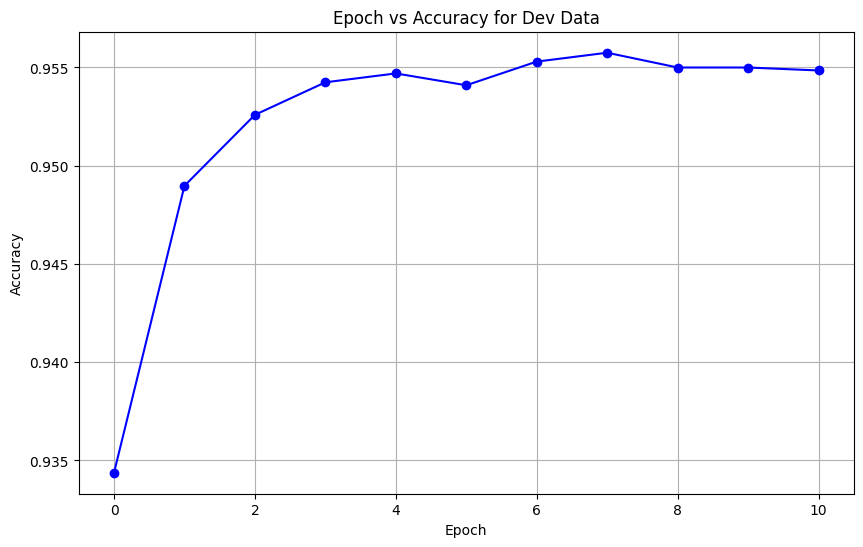

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

# Plot epoch vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, accuracy_list, marker='o', color='b', linestyle='-')
plt.title('Epoch vs Accuracy for Dev Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()



In [56]:
# Generate confusion matrix
conf_matrix = confusion_matrix(real_dev_tags, pred_dev_tags)

# Print evaluation metrics
accuracy = accuracy_score(real_dev_tags, pred_dev_tags)
recall_micro = recall_score(real_dev_tags, pred_dev_tags, average='micro')
recall_macro = recall_score(real_dev_tags, pred_dev_tags, average='macro')
f1_micro = f1_score(real_dev_tags, pred_dev_tags, average='micro')
f1_macro = f1_score(real_dev_tags, pred_dev_tags, average='macro')



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
from tabulate import tabulate

# Tabular format for evaluation metrics
metrics_data = [
    ["Accuracy", accuracy],
    ["Recall (micro)", recall_micro],
    ["Recall (macro)", recall_macro],
    ["F1 Score (micro)", f1_micro],
    ["F1 Score (macro)", f1_macro]
]

# Print evaluation metrics in tabular format
print("Evaluation Metrics for Dev Data:")
print(tabulate(metrics_data, headers=["Metric", "Value"], tablefmt="grid"))


Evaluation Metrics for Dev Data:
+------------------+----------+
| Metric           |    Value |
+==================+==========+
| Accuracy         | 0.954094 |
+------------------+----------+
| Recall (micro)   | 0.954094 |
+------------------+----------+
| Recall (macro)   | 0.879093 |
+------------------+----------+
| F1 Score (micro) | 0.954094 |
+------------------+----------+
| F1 Score (macro) | 0.868911 |
+------------------+----------+


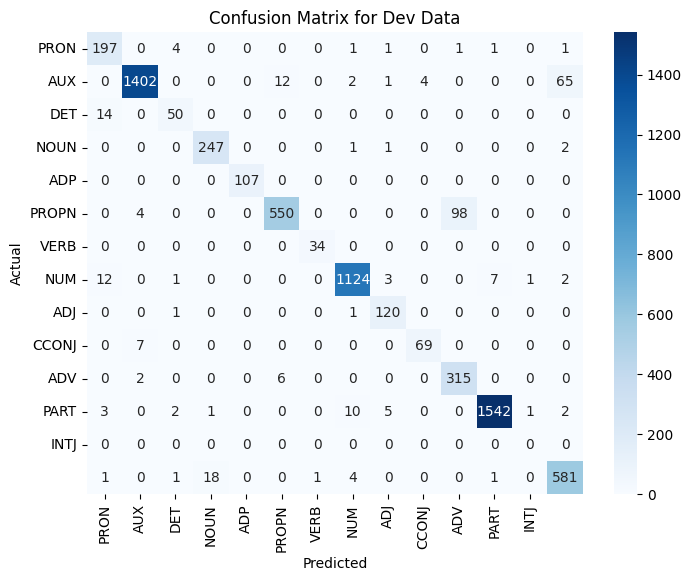

In [42]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=pos_index.keys(), yticklabels=pos_index.keys())
plt.title('Confusion Matrix for Dev Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [43]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [44]:
real_test_tags=[]
pred_test_tags=[]
model.eval()
with torch.no_grad():
    correct = 0
    samples = 0

    for sentence, tags in test_data:
        inputs = prepare_sequence(sentence, word_index)
        tag_scores = model(inputs)
        _, predicted = torch.max(tag_scores, 1)
        ret = []
        for i in range(len(predicted)):
            for key, value in pos_index.items():
                if predicted[i] == value:
                    ret.append(key)
        real_test_tags.extend(ret)
        pred_test_tags.extend(tags)
        samples += len(tags)

        # Compare predicted tags with actual tags and count correct predictions
        for i in range(len(ret)):
            if ret[i] == tags[i]:
                correct += 1

    # Calculate accuracy
    accuracy = (correct / samples) * 100
    print("Accuracy on test set:", accuracy)

Accuracy on test set: 96.03343465045593


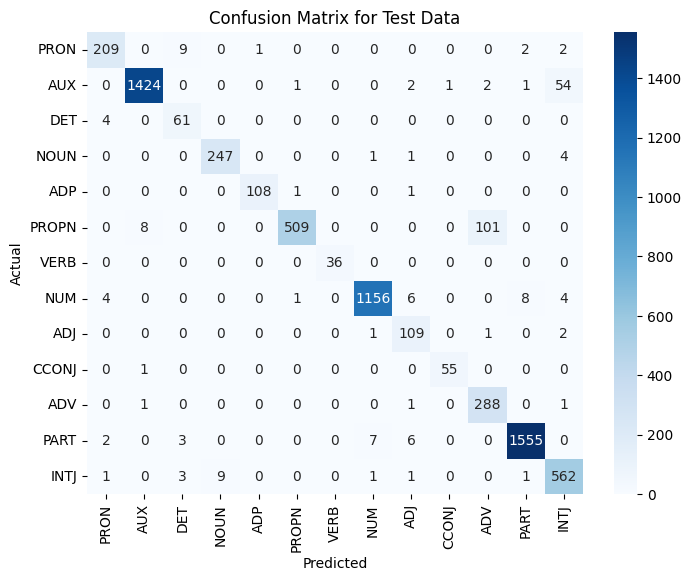

In [45]:
# Compute confusion matrix
conf_matrix_test = confusion_matrix(real_test_tags, pred_test_tags)



# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', fmt='g', xticklabels=pos_index.keys(), yticklabels=pos_index.keys())
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [46]:

# Compute evaluation metrics
accuracy_test = accuracy_score(real_test_tags, pred_test_tags)
recall_micro_test = recall_score(real_test_tags, pred_test_tags, average='micro')
recall_macro_test = recall_score(real_test_tags, pred_test_tags, average='macro')
f1_micro_test = f1_score(real_test_tags, pred_test_tags, average='micro')
f1_macro_test = f1_score(real_test_tags, pred_test_tags, average='macro')

In [58]:
from tabulate import tabulate

# Tabular format for evaluation metrics
test_metrics_data = [
    ["Accuracy", accuracy_test],
    ["Recall (micro)", recall_micro_test],
    ["Recall (macro)", recall_macro_test],
    ["F1 Score (micro)", f1_micro_test],
    ["F1 Score (macro)", f1_macro_test]
]

# Print evaluation metrics in tabular format
print("Evaluation Metrics for Test Data:")
print(tabulate(test_metrics_data, headers=["Metric", "Value"], tablefmt="grid"))


Evaluation Metrics for Test Data:
+------------------+----------+
| Metric           |    Value |
+==================+==========+
| Accuracy         | 0.960334 |
+------------------+----------+
| Recall (micro)   | 0.960334 |
+------------------+----------+
| Recall (macro)   | 0.961087 |
+------------------+----------+
| F1 Score (micro) | 0.960334 |
+------------------+----------+
| F1 Score (macro) | 0.944895 |
+------------------+----------+


In [15]:
torch.save(model, f"/content/my_model_lstm_reLu.pt")